In [36]:
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing()
print(california.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [37]:
import pandas as pd
df = pd.DataFrame(california.data, columns=california.feature_names)
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [38]:
import numpy as np
# Обчислюємо середні значення координат для того, щоб створити центроїд та перетворити
# Ознаки довготи та широти у нову ознаку - відстань до центроїду, щоб прибрати кореляцію
mean_lat = df['Latitude'].mean()
mean_lon = df['Longitude'].mean()
df['DistanceFromCenter'] = np.sqrt((df['Latitude'] - mean_lat)**2 + (df['Longitude'] - mean_lon)**2)

print(df[['Latitude', 'Longitude', 'DistanceFromCenter']].head())
df.drop(columns=['Latitude', 'Longitude'], inplace=True)

   Latitude  Longitude  DistanceFromCenter
0     37.88    -122.23            3.483001
1     37.86    -122.22            3.462466
2     37.85    -122.24            3.471400
3     37.85    -122.25            3.479098
4     37.85    -122.25            3.479098


In [39]:
import numpy as np
from scipy.stats import zscore

# Список колонок для перевірки на аномалії
cols = ['AveRooms', 'AveBedrms', 'AveOccup', 'Population']
threshold = 3
z_scores = df[cols].apply(zscore)
mask = np.abs(z_scores) < threshold
rows_to_keep = mask.all(axis=1)
df_clean = df[rows_to_keep].copy()
print("Початковий розмір даних:", df.shape)
print("Розмір після видалення викидів:", df_clean.shape)


Початковий розмір даних: (20640, 7)
Розмір після видалення викидів: (20135, 7)


Матриця кореляцій:
                      MedInc  HouseAge  AveRooms  AveBedrms  Population  \
MedInc              1.000000 -0.115877  0.656478  -0.167024   -0.020473   
HouseAge           -0.115877  1.000000 -0.215724  -0.125943   -0.289941   
AveRooms            0.656478 -0.215724  1.000000   0.300095   -0.086841   
AveBedrms          -0.167024 -0.125943  0.300095   1.000000   -0.045160   
Population         -0.020473 -0.289941 -0.086841  -0.045160    1.000000   
AveOccup           -0.062207 -0.000518 -0.042819  -0.081026    0.177735   
DistanceFromCenter -0.037161 -0.045048  0.101239   0.113549   -0.077016   

                    AveOccup  DistanceFromCenter  
MedInc             -0.062207           -0.037161  
HouseAge           -0.000518           -0.045048  
AveRooms           -0.042819            0.101239  
AveBedrms          -0.081026            0.113549  
Population          0.177735           -0.077016  
AveOccup            1.000000           -0.158221  
DistanceFromCenter -0.1

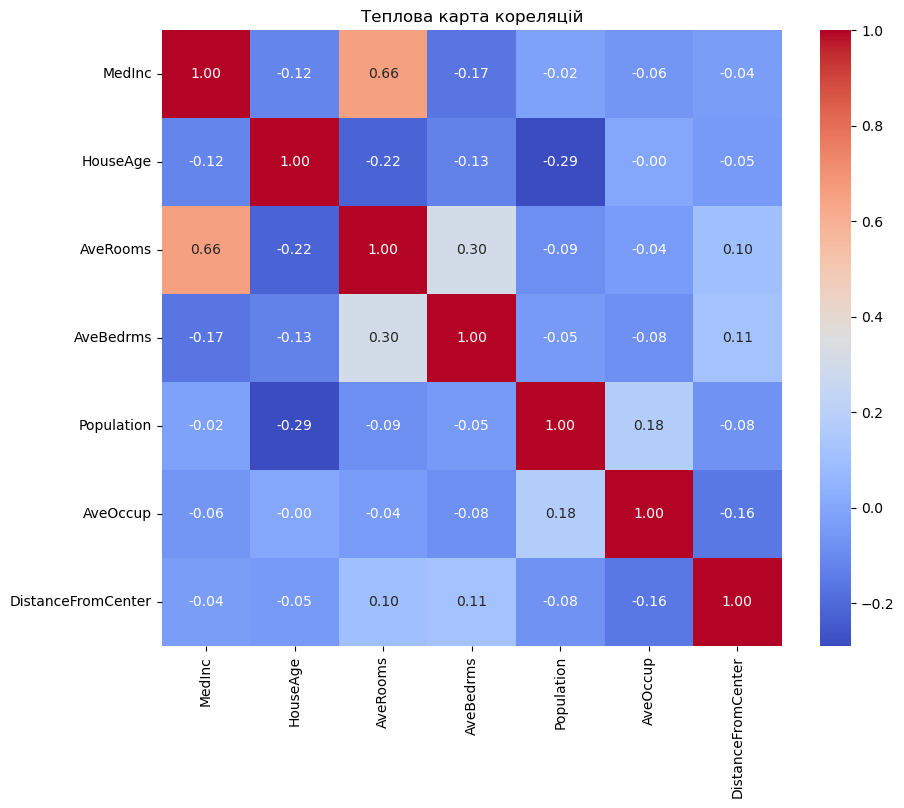

In [40]:
import seaborn as sns  
import matplotlib.pyplot as plt  # для побудови графіків
correlation_matrix = df_clean.corr()
print("Матриця кореляцій:")
print(correlation_matrix)

# Створюємо теплову карту (heatmap) для зручного перегляду кореляцій
plt.figure(figsize=(10, 8))  # налаштовуємо розмір графіка
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Теплова карта кореляцій")
plt.show()

In [41]:
# Створення нової ознаки, що показує, чи було значення обрізано
# додало до R2 - 0.57 -> 0.58
df_clean['HouseAge_aged'] = (df_clean['HouseAge'] == 52).astype(int)

In [42]:
# Імпортуємо необхідні модулі
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

# Приведення AveRooms до квадрата оскільки кореляція занадто сильна
# додало кілька пунктів до R2 - 0.58 -> 0.62
df_clean['AveRooms_sq'] = df_clean['AveRooms'] ** 2
df_clean.drop(columns=['AveRooms'], inplace=True)

# "MedInc" - цільова змінна
# Розділяємо дані на ознаки (X) та цільову змінну (y)
X = df_clean.drop(columns=["MedInc"], axis=1)
y = df_clean["MedInc"]

# Крок 4. Розбиваємо дані на навчальну та тестову вибірки (80% навчальна, 20% тестова)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Крок 5. Нормалізуємо ознаки за допомогою StandardScaler
scaler = StandardScaler()
# Навчаємо scaler на навчальній вибірці та перетворюємо її
X_train_scaled = scaler.fit_transform(X_train)
# Використовуємо навчену модель для перетворення тестової вибірки
X_test_scaled = scaler.transform(X_test)

# Крок 6. Побудова моделі лінійної регресії
model = LinearRegression()
# Навчаємо модель на нормалізованих даних навчальної вибірки
model.fit(X_train_scaled, y_train)
# Отримуємо передбачення для тестової вибірки
y_pred = model.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Вивід показників
print(f'R2: {r2:.2f} | MAE: {mae:.2f} | MAPE: {mape:.2f}')

R2: 0.62 | MAE: 0.87 | MAPE: 0.27


In [43]:
# from ydata_profiling import ProfileReport
# report = ProfileReport(
#     df_clean,
#     title='California Housing Dataset')
# 
# report.to_notebook_iframe()